<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/Neural_Operator_BurgesEq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://zongyi-li.github.io/neural-operator/

Epoch 0: Loss = 0.730279
Epoch 50: Loss = 0.003318
Epoch 100: Loss = 0.000563
Epoch 150: Loss = 0.000209
Epoch 200: Loss = 0.000103
Epoch 250: Loss = 0.000093
Epoch 300: Loss = 0.000048
Epoch 350: Loss = 0.000023
Epoch 400: Loss = 0.000014
Epoch 450: Loss = 0.000025


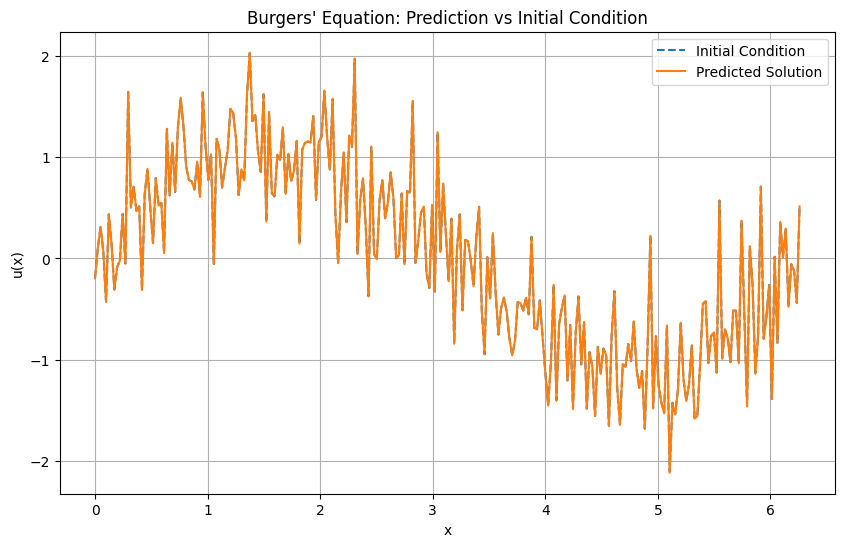

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# Burgers' equation parameters
# u_t + u * u_x = \nu * u_xx, \nu is the viscosity
# Discretized domain
N = 256  # Number of spatial grid points
L = 2 * np.pi  # Domain length
x = np.linspace(0, L, N, endpoint=False)  # Spatial grid

def generate_initial_condition():
    """Generate random initial conditions for Burgers' equation"""
    return np.sin(x) + 0.5 * np.random.normal(0, 1, size=x.shape)

# Neural Operator model (Fourier Neural Operator)
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes, width):
        super(FourierNeuralOperator, self).__init__()
        self.modes = modes  # Number of Fourier modes to keep
        self.width = width  # Width of the layers

        self.fc0 = nn.Linear(1, self.width)  # Initial fully connected layer

        self.conv = nn.ModuleList([
            SpectralConv1d(self.width, self.width, self.modes) for _ in range(4)
        ])

        self.w = nn.ModuleList([nn.Conv1d(self.width, self.width, 1) for _ in range(4)])
        self.fc1 = nn.Linear(self.width, self.width)
        self.fc2 = nn.Linear(self.width, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        for i in range(len(self.conv)):
            x = self.conv[i](x) + self.w[i](x)
            x = F.gelu(x)
        x = x.permute(0, 2, 1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

class SpectralConv1d(nn.Module):
    """1D Fourier layer for learning spectral operations"""
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize, channels, size = x.shape
        x_ft = torch.fft.rfft(x)  # Perform FFT
        out_ft = torch.zeros(batchsize, self.out_channels, x_ft.shape[-1], dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=size)  # Perform inverse FFT
        return x

# Model parameters
modes = 16  # Number of Fourier modes
width = 64  # Width of the network
model = FourierNeuralOperator(modes, width)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

def train(model, epochs=500, batch_size=20):
    """Train the Fourier Neural Operator on Burgers' equation"""
    for epoch in range(epochs):
        optimizer.zero_grad()
        u0 = generate_initial_condition()
        u0_torch = torch.tensor(u0, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(u0_torch)
        loss = loss_fn(pred, u0_torch)  # Compare prediction to initial condition
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Train the model
train(model)

def infer_and_visualize(model):
    """Use the trained model to predict and visualize results"""
    model.eval()  # Set the model to evaluation mode

    # Generate a new initial condition for inference
    u0 = generate_initial_condition()
    u0_torch = torch.tensor(u0, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    # Perform prediction
    with torch.no_grad():
        pred = model(u0_torch).squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x, u0, label="Initial Condition", linestyle="--")
    plt.plot(x, pred, label="Predicted Solution", linestyle="-")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Burgers' Equation: Prediction vs Initial Condition")
    plt.legend()
    plt.grid()
    plt.show()

# Perform inference and visualization
infer_and_visualize(model)


Epoch 0: Loss = 0.511512
Epoch 50: Loss = 0.002952
Epoch 100: Loss = 0.000122
Epoch 150: Loss = 0.000036
Epoch 200: Loss = 0.000014
Epoch 250: Loss = 0.000009
Epoch 300: Loss = 0.000006
Epoch 350: Loss = 0.000006
Epoch 400: Loss = 0.000007
Epoch 450: Loss = 0.000005


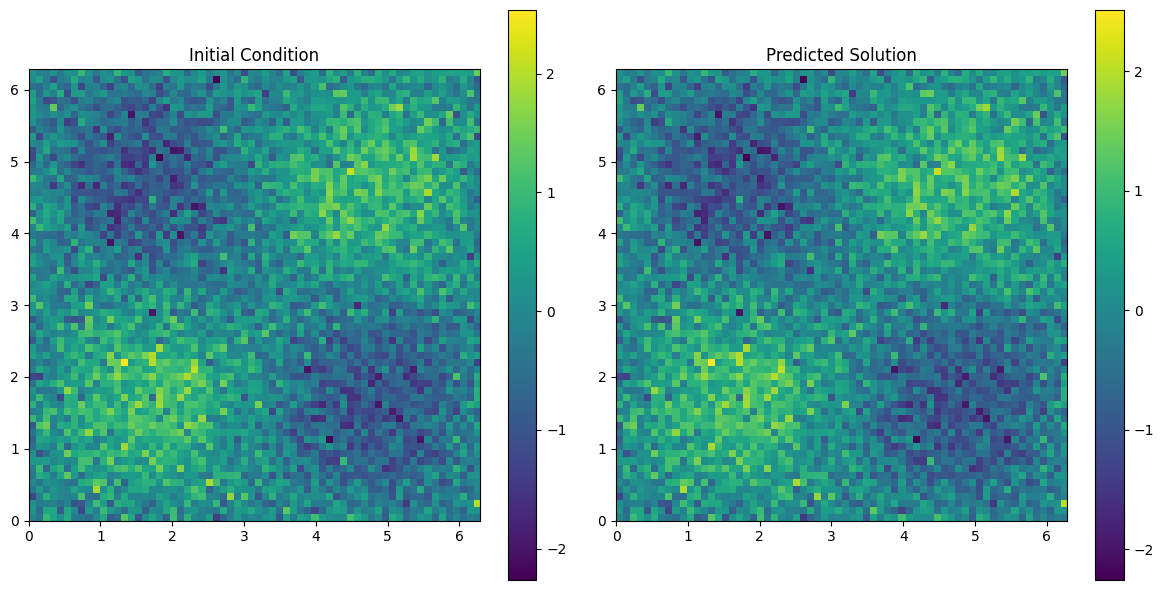

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# Burgers' equation parameters (2D version)
# u_t + u * u_x + v * u_y = \nu * (u_xx + u_yy), \nu is the viscosity
# Discretized domain
N = 64  # Number of spatial grid points in each dimension
L = 2 * np.pi  # Domain length
x = np.linspace(0, L, N, endpoint=False)  # Spatial grid
y = np.linspace(0, L, N, endpoint=False)
x, y = np.meshgrid(x, y)  # Create 2D grid


def generate_initial_condition_2d():
    """Generate random initial conditions for 2D Burgers' equation"""
    return np.sin(x) * np.sin(y) + 0.5 * np.random.normal(0, 1, size=x.shape)

# Neural Operator model (Fourier Neural Operator for 2D)
class FourierNeuralOperator2D(nn.Module):
    def __init__(self, modes, width):
        super(FourierNeuralOperator2D, self).__init__()
        self.modes = modes  # Number of Fourier modes to keep
        self.width = width  # Width of the layers

        self.fc0 = nn.Linear(1, self.width)  # Initial fully connected layer

        self.conv = nn.ModuleList([
            SpectralConv2d(self.width, self.width, self.modes) for _ in range(4)
        ])

        self.w = nn.ModuleList([nn.Conv2d(self.width, self.width, 1) for _ in range(4)])
        self.fc1 = nn.Linear(self.width, self.width)
        self.fc2 = nn.Linear(self.width, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        for i in range(len(self.conv)):
            x = self.conv[i](x) + self.w[i](x)
            x = F.gelu(x)
        x = x.permute(0, 2, 3, 1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

class SpectralConv2d(nn.Module):
    """2D Fourier layer for learning spectral operations"""
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, self.modes, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize, channels, height, width = x.shape
        x_ft = torch.fft.rfft2(x)  # Perform 2D FFT
        out_ft = torch.zeros(batchsize, self.out_channels, x_ft.shape[-2], x_ft.shape[-1], dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes, :self.modes] = self.compl_mul2d(x_ft[:, :, :self.modes, :self.modes], self.weights)
        x = torch.fft.irfft2(out_ft, s=(height, width))  # Perform inverse 2D FFT
        return x

# Model parameters
modes = 16  # Number of Fourier modes
width = 64  # Width of the network
model_2d = FourierNeuralOperator2D(modes, width)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = Adam(model_2d.parameters(), lr=0.001)

def train_2d(model, epochs=500, batch_size=20):
    """Train the Fourier Neural Operator on 2D Burgers' equation"""
    for epoch in range(epochs):
        optimizer.zero_grad()
        u0 = generate_initial_condition_2d()
        u0_torch = torch.tensor(u0, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        pred = model(u0_torch)
        loss = loss_fn(pred, u0_torch)  # Compare prediction to initial condition
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Train the model
train_2d(model_2d)

def infer_and_visualize_2d(model):
    """Use the trained model to predict and visualize results in 2D"""
    model.eval()  # Set the model to evaluation mode

    # Generate a new initial condition for inference
    u0 = generate_initial_condition_2d()
    u0_torch = torch.tensor(u0, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    # Perform prediction
    with torch.no_grad():
        pred = model(u0_torch).squeeze().numpy()

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    im0 = axes[0].imshow(u0, extent=[0, L, 0, L], origin="lower", cmap="viridis")
    axes[0].set_title("Initial Condition")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pred, extent=[0, L, 0, L], origin="lower", cmap="viridis")
    axes[1].set_title("Predicted Solution")
    plt.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()

# Perform inference and visualization
infer_and_visualize_2d(model_2d)


| **特性**             | **① 通常のCAE学習**                     | **② Neural Operator**                     | **③ PINN**                                  |
|-----------------------|-----------------------------------------|-------------------------------------------|---------------------------------------------|
| **物理法則の考慮**   | 明示的に考慮しない                     | FFTやスペクトル操作を通じて間接的に考慮  | 損失関数に明示的に物理法則を組み込む       |
| **データ依存性**     | CAEデータに完全依存                   | CAEデータに依存                          | データが少なくても物理法則で補完可能       |
| **外挿性**           | 外挿に弱い                            | データ範囲外でも一定の性能を発揮        | 外挿に非常に強い                          |
| **計算コスト**       | 比較的低い                            | ①よりやや高い（FFT計算などの影響）      | 高次元問題では非常に高い場合がある        |
| **高速推論**         | 学習後の推論は高速                   | 高速                                     | 問題の次元によって推論速度が制限される    |
| **適用範囲**         | 小規模なCAE学習                     | 高次元・大規模問題、スペクトル的特徴学習 | データ不足時や未知領域の予測に適する     |
